In [1]:
%load_ext autoreload
%autoreload 2

from time import time

import re
import numpy as np
from matplotlib import pyplot
import os
# os.chdir('/home/yychen/sciPENN_codes-master/Experiments')
from math import ceil
from scipy.stats import spearmanr

import scanpy as sc
from scanpy import read
import pandas as pd

from read_monocyte_data import read_data
from sciPENN.sciPENN_API import sciPENN_API

In [2]:
os.getcwd()

'/home/yychen/sciPENN_codes-master/Experiments'

In [3]:
adata_gene, adata_protein = read_data(cell_normalize = False, log_normalize = False, feature_normalize = False,
                   dir_path = '../Data/monocytes_mingyao/cite_seq', subset_hvg = False)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

In [10]:
tmp = adata_protein.copy()
sc.pp.normalize_total(tmp)
sc.pp.log1p(tmp)
sums = tmp.X.sum(axis = 0) # 113个蛋白
samples = ((tmp.X > 0.0001).sum(axis = 0))
expression = sums/samples
adata_protein = adata_protein[:, expression > 0.8].copy()
adata_protein

113


AnnData object with n_obs × n_vars = 37112 × 113
    obs: 'patient'
    var: 'Common Name', 'expression_type', 'n_counts'
    layers: 'raw'

In [11]:
train_patientset = ['RPM211A', 'RPM211B', 'RPM232A', 'RPM232B']
test_patientset = ['RPM215A', 'RPM215B', 'RPM218A', 'RPM218B']
train_patients = [x in train_patientset for x in adata_gene.obs['patient']]
test_patients = [x in test_patientset for x in adata_gene.obs['patient']]

adata_gene, adata_gene_test = adata_gene[train_patients], adata_gene[test_patients]
adata_protein, adata_protein_test = adata_protein[train_patients], adata_protein[test_patients]

In [12]:
sciPENN = sciPENN_API([adata_gene], [adata_protein], adata_gene_test, train_batchkeys = ['patient'], test_batchkey = 'patient')

Trying to set attribute `.obs` of view, copying.


Searching for GPU
GPU detected, using GPU


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.



QC Filtering Training Cells
QC Filtering Testing Cells

QC Filtering Training Genes
QC Filtering Testing Genes

Normalizing Training Cells
Normalizing Testing Cells

Log-Normalizing Training Data
Log-Normalizing Testing Data

Finding HVGs


... storing 'patient' as categorical
... storing 'batch' as categorical
... storing 'Dataset' as categorical
... storing 'expression_type' as categorical
/home/yychen/.conda/envs/scipenn_env/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)



Normalizing Gene Training Data by Batch


100%|██████████| 4/4 [00:00<00:00,  9.66it/s]



Normalizing Protein Training Data by Batch


100%|██████████| 4/4 [00:00<00:00, 45.03it/s]



Normalizing Gene Testing Data by Batch


100%|██████████| 4/4 [00:00<00:00, 13.03it/s]


In [17]:
adata_protein_test

View of AnnData object with n_obs × n_vars = 17596 × 113
    obs: 'patient'
    var: 'Common Name', 'expression_type', 'n_counts'
    layers: 'raw'

In [18]:
start = time()
sciPENN.train(n_epochs=10000, weights_dir = "weights_dir/monocyte_to_monocyte", load=False)
imputed_test = sciPENN.predict()
time() - start

Epoch 0 prediction loss = 1.385
Epoch 1 prediction loss = 1.113
Epoch 2 prediction loss = 1.112
Epoch 3 prediction loss = 1.100
Epoch 4 prediction loss = 1.099
Epoch 5 prediction loss = 1.117
Epoch 6 prediction loss = 1.093
Epoch 7 prediction loss = 1.099
Epoch 8 prediction loss = 1.109
Epoch 9 prediction loss = 1.079
Epoch 10 prediction loss = 1.097
Epoch 11 prediction loss = 1.105
Epoch 12 prediction loss = 1.097
Epoch 13 prediction loss = 1.103
Epoch 14 prediction loss = 1.085
Decaying loss to 0.0001
Epoch 15 prediction loss = 1.019
Epoch 16 prediction loss = 1.033
Epoch 17 prediction loss = 1.033
Epoch 18 prediction loss = 1.040
Epoch 19 prediction loss = 1.023
Epoch 20 prediction loss = 1.023
Decaying loss to 1e-05
Epoch 21 prediction loss = 1.010
Epoch 22 prediction loss = 1.008
Epoch 23 prediction loss = 1.018
Epoch 24 prediction loss = 1.028
Epoch 25 prediction loss = 1.024
Epoch 26 prediction loss = 1.016
Decaying loss to 1.0000000000000002e-06
Epoch 27 prediction loss = 1.014

1305.30788064003

In [19]:
embedding = sciPENN.embed()
embedding.write("scipenn_monocyteembedding.h5ad")

... storing 'patient' as categorical
... storing 'batch' as categorical


In [21]:
embedding

AnnData object with n_obs × n_vars = 37018 × 512
    obs: 'patient', 'batch'

In [20]:
imputed_test

AnnData object with n_obs × n_vars = 17519 × 113
    obs: 'patient', 'batch', 'scale_factor'
    layers: 'q10', 'q25', 'q75', 'q90'

In [22]:
adata_protein_test = adata_protein_test[imputed_test.obs.index]

sc.pp.normalize_total(adata_protein_test)
sc.pp.log1p(adata_protein_test)
sc.pp.filter_genes(adata_protein_test, min_counts = 1)

common_proteins = np.intersect1d(imputed_test.var.index, adata_protein_test.var.index)

adata_protein_test = adata_protein_test[:, common_proteins]
adata_protein_test.layers['imputed'] = imputed_test[:, common_proteins].X
adata_protein_test.layers.update(imputed_test[:, common_proteins].layers)

patients = np.unique(adata_protein_test.obs['patient'].values)

for patient in patients:
    indices = [x == patient for x in adata_protein_test.obs['patient']]
    sub_adata = adata_protein_test[indices]

    sc.pp.scale(sub_adata)
    adata_protein_test[indices] = sub_adata.X

/home/yychen/.conda/envs/scipenn_env/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/yychen/.conda/envs/scipenn_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
def corr2_coeff(A, B, pearson = True):
    if pearson:
        # Rowwise mean of input arrays & subtract from input arrays themeselves
        A_mA = A - A.mean(1)[:, None]
        B_mB = B - B.mean(1)[:, None]

        # Sum of squares across rows
        ssA = (A_mA**2).sum(1)
        ssB = (B_mB**2).sum(1)

        # Finally get corr coeff
        corr_mat = np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))
        
        return corr_mat[range(corr_mat.shape[0]), range(corr_mat.shape[0])]
    
    else:
        corrs = [0.] * A.shape[0]
        
        for i in range(A.shape[0]):
            corrs[i] = spearmanr(A[i], B[i])[0]
            
        return corrs

In [24]:
corrs = corr2_coeff(adata_protein_test.layers["imputed"].T, adata_protein_test.X.T)
corrs = pd.DataFrame(corrs)
corrs.index = adata_protein_test.var.index
corrs = corrs.dropna()

In [26]:
MSEs = ((adata_protein_test.X - adata_protein_test.layers["imputed"])**2).mean(axis = 0)**(1/2)

protein_table = pd.DataFrame(np.concatenate((corrs.to_numpy(), np.expand_dims(MSEs, axis = 1), adata_protein_test.layers["raw"].mean(axis = 0, keepdims = True).T), axis = 1), 
                             index = corrs.index, columns = ["Correlations", "RMSE", "Mean Expression"])

protein_table["Log-Mean Expression"] = np.log(protein_table["Mean Expression"])

In [27]:
sq = lambda x, y: (x - y)**2

In [28]:
corrs_table = np.zeros((adata_protein_test.shape[1], len(np.unique(adata_protein_test.obs["patient"]))))
sq_table = corrs_table.copy()

i = 0
for patient in np.unique(adata_protein_test.obs["patient"]):
    truth = adata_protein_test[adata_protein_test.obs["patient"] == patient].X.copy()
    imputed = adata_protein_test.layers["imputed"][adata_protein_test.obs["patient"] == patient].copy()

    corrs_table[:, i] = corr2_coeff(truth.T, imputed.T)
    sq_table[:, i] = sq(truth, imputed).mean(axis = 0)
    i += 1

if np.isnan(corrs_table).sum() > 0:
    corrs_table[np.isnan(corrs_table)] = 0

In [29]:
corrs_table = pd.DataFrame(corrs_table)
sq_table = pd.DataFrame(sq_table)
corrs_table.index, corrs_table.columns = adata_protein_test.var.index, np.unique(adata_protein_test.obs["patient"])
sq_table.index, sq_table.columns = adata_protein_test.var.index, np.unique(adata_protein_test.obs["patient"])

In [30]:
corrs_table.mean(axis = 0)

RPM215A    0.332600
RPM215B    0.485638
RPM218A    0.363333
RPM218B    0.444243
dtype: float64

In [31]:
corrs_table.mean(axis = 0).mean()

0.4064533480918766

In [32]:
corrs_table.to_csv('corrs_results/scipenn_monocyte.csv')

In [33]:
sq_table.mean(axis = 0)

RPM215A    0.858145
RPM215B    0.736378
RPM218A    0.825809
RPM218B    0.766245
dtype: float64

In [34]:
sq_table.mean().mean()

0.7966442524199991

In [35]:
sq_table.loc['CD16']

RPM215A    0.256501
RPM215B    0.245137
RPM218A    0.273592
RPM218B    0.281998
Name: CD16, dtype: float64

In [36]:
sq_table.to_csv('mse_results/scipenn_monocyte.csv')

In [37]:
corrs_table.loc['CD16']

RPM215A    0.868187
RPM215B    0.891583
RPM218A    0.854823
RPM218B    0.856301
Name: CD16, dtype: float64

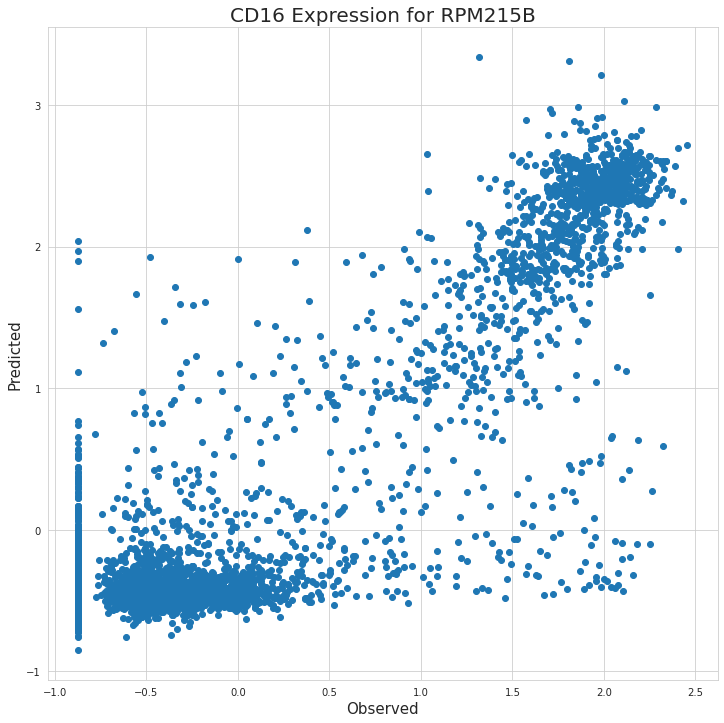

In [38]:
gene, subject = "CD16", "RPM215B"

x = (adata_protein_test.obs['patient'].values == subject).reshape(-1, 1)
y = adata_protein_test.var.index == gene

true, observed = adata_protein_test[x, y].X, adata_protein_test[x, y].layers['imputed']

fig, axes = pyplot.subplots(1, 1, figsize = (12, 12))

axes.scatter(true, observed)
axes.set_title(f"{gene} Expression for {subject}", fontsize = 20)
axes.set_xlabel("Observed", fontsize = 15)
axes.set_ylabel("Predicted", fontsize = 15)
fig.savefig('grantfig.jpeg', dpi = 300)

In [39]:
r95 = (adata_protein_test.X < adata_protein_test.layers['q75'])
l95 = (adata_protein_test.X > adata_protein_test.layers['q25'])

print(f"Effective Coverage Probability for Nominal 50% PI: {(r95*l95).mean():.3f}")

Effective Coverage Probability for Nominal 50% PI: 0.448


In [40]:
r95 = (adata_protein_test.X < adata_protein_test.layers['q90'])
l95 = (adata_protein_test.X > adata_protein_test.layers['q10'])

print(f"Effective Coverage Probability for Nominal 80% PI: {(r95*l95).mean():.3f}")

Effective Coverage Probability for Nominal 80% PI: 0.698


In [41]:
adata_protein_test.write("scipenn_monocytefeatures.h5ad")

... storing 'patient' as categorical
... storing 'expression_type' as categorical


In [42]:
lengths = adata_protein_test.layers['q75'] - adata_protein_test.layers['q25']
print(f"Mean 50% PI: {lengths.mean():.2f}")

Mean 50% PI: 1.08
